# AIMS CDT Signal Processing Lab Session 3
## Graph Neural Networks
Xiaowen Dong (xdong@robots.ox.ac.uk), Henry Kenlay (henrykenlay@pm.me)
## Introduction

Acknowlegement: This lab session was partially inspired by [this online tutorial](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX). It was first created by Henry Kenlay and subsequently improved by Yin-Cong Zhi, Pierre Osselin, Bohan Tang, Scott le Reux, Ning Zhang and Jacob Bamberger in the Machine Learning Research Group in the Department of Engineering Science at Oxford University.

In this lab, we will be looking into implementing graph neural networks (GNNs). This is a class of machine learning models that generalise classical neural network architectures to deal with graph-structured data. We will be using PyTorch Geometric (PyG), a Python package for graph neural network operations. In addition, we will be using NetworkX for processing and visualising network data.

PyTorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/ <br>
NetworkX: https://networkx.org

If you are using Colab you can use a GPU backend by navigating to `Runtime > Change runtime type`, and choosing GPU under Hardware accelerator. If you are running the notebook locally you can use the [PyG installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) to generate an appropriate pip install command for your hardware.

The cells below will install PyTorch Geometric using CUDA. You can find which version of torch and cuda is currently running by the command below, and make adjustment of the installation line.

In [ ]:
!python -c "import torch; print(torch.__version__)"

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

In [5]:
# Import required packages.
import numpy as np
import pandas as pd
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch.nn import Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from copy import deepcopy
from sklearn.manifold import TSNE

plt.rcParams['image.cmap'] = 'Set2' # choose matplotlib colormap

/Users/fracapuano/miniconda3/envs/signalenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will be working with the Cora citation dataset made popular by the work on graph convolutional networks of [Kipf and Welling (2017)](https://arxiv.org/abs/1609.02907). The nodes in the Cora dataset represents papers, and edges represent citation links between them. For simplicity, we treat the network as undirected (there is a link between paper A and B if either A cites B or vice versa). In addition, each node comes with a set of attributes (bag-of-words features extracted from the corresponding paper) and a label (the field where the paper was published).


First of all, load the Cora dataset and compute some statistics assocaited with the network:

In [6]:
dataset = Planetoid(root='data/', name='cora', pre_transform=ToUndirected())

Processing...
Done!


**Note: How PyTorch represents the data**

The `dataset.data` variable contains information about the Cora citation graph, the node features and the node labels. Nodes are indexed $0, \ldots, n-1$. Edges are given by the $2 \times |E|$ tensor `dataset.data.edge_index` where each column contains two numbers $u$ and $v$ representing a directed edge `u → v`. In PyTorch Geometric all graphs are directed. We can represent an undirected graph by representing each undirected edge `u ~ v` with two directed edges `u → v` and  `v → u`. Because we are treating Cora as an undirected graph, we divide `dataset.data.num_edges` by 2 to count the number of (undirected) edges. The node features are stored in the $n \times d$ matrix `dataset.data.x` with the $i$th row being the feature vector for node $i$. Finally node labels are given by the vector `dataset.data.y` where the $i$th entry is the label for node $i$.

In [7]:
print('Number of nodes:', dataset.data.num_nodes)
print('Number of edges:', dataset.data.num_edges // 2)
print('Feature dimension:', dataset.data.x.size(1))

Number of nodes: 2708
Number of edges: 5278
Feature dimension: 1433


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/1645062455.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print('Number of nodes:', dataset.data.num_nodes)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/1645062455.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print('Number of edges:', dataset.data.num_edges // 2)
/var/folders/hz

A quick look at node label statistics. Recall that the nodes represent a research paper. The corresponding label is the research subfield.  

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/275637489.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  labels = dataset.data.y


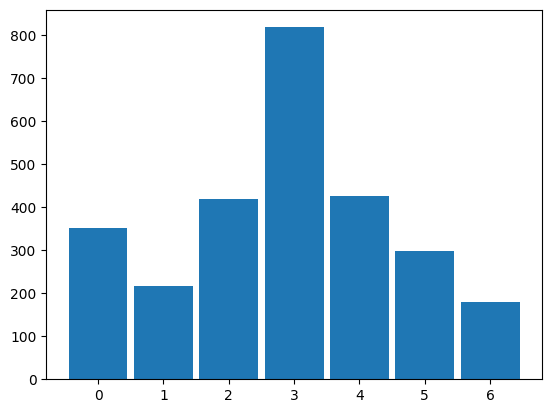

In [8]:
#Distribution of node labels?
fig, ax = plt.subplots()
labels = dataset.data.y
ax.hist(labels, bins=np.arange(8)-0.5, rwidth=0.9)
print()

Recall that the nodes represent a research paper. The corresponding label is the research subfield. The dictionary below gives the subfield associated to each label.



In [9]:
label_map = {0: 'Theory',
             1: 'Reinforcement Learning',
             2: 'Genetic Algorithms',
             3: 'Neural Networks',
             4: 'Probabilistic Methods',
             5: 'Case Based',
             6: 'Rule Learning'}

The graph is too large to visualise effectively so visualise instead a subset of the data.

In [10]:
def plot_subset(data, ax, pos, seed=0):
    graph_nx = to_networkx(data, node_attrs=['y'], to_undirected=True)
    subgraph_nx = graph_nx.subgraph(pos.keys())

    # plot graph
    nodelist = list(subgraph_nx.nodes())
    node_size = [10*(subgraph_nx.degree(node)+1) for node in nodelist]
    color = [graph_nx.nodes(data=True)[node]['y'] for node in nodelist]
    nx.draw_networkx_nodes(subgraph_nx, pos = pos, nodelist=nodelist, node_size=node_size, node_color=color, ax=ax)
    nx.draw_networkx_edges(subgraph_nx, pos = pos, nodelist=nodelist, alpha=0.2, ax=ax)
    ax.axis("off")

def subgraph_layout(data, seed=0):
    """Defines coordinates for a subsgraph of data."""

    # set seed
    np.random.seed(seed)

    # change to networkx and select largest connected component
    data = deepcopy(data)
    graph_nx = to_networkx(data, node_attrs=['y'], to_undirected=True)
    subgraph_nx = graph_nx.subgraph(max(nx.connected_components(graph_nx), key=len))

    # select a subgraph
    random_node = np.random.choice(subgraph_nx.nodes())
    subgraph_nx = nx.ego_graph(subgraph_nx, random_node, radius=3)

    # calculate pos
    pos = nx.spring_layout(subgraph_nx)
    return pos

In [11]:
[i for i in plt.get_cmap().colors]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/4155154915.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  pos = subgraph_layout(dataset.data, seed=0)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/4155154915.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  plot_subset(dataset.data, ax, pos)


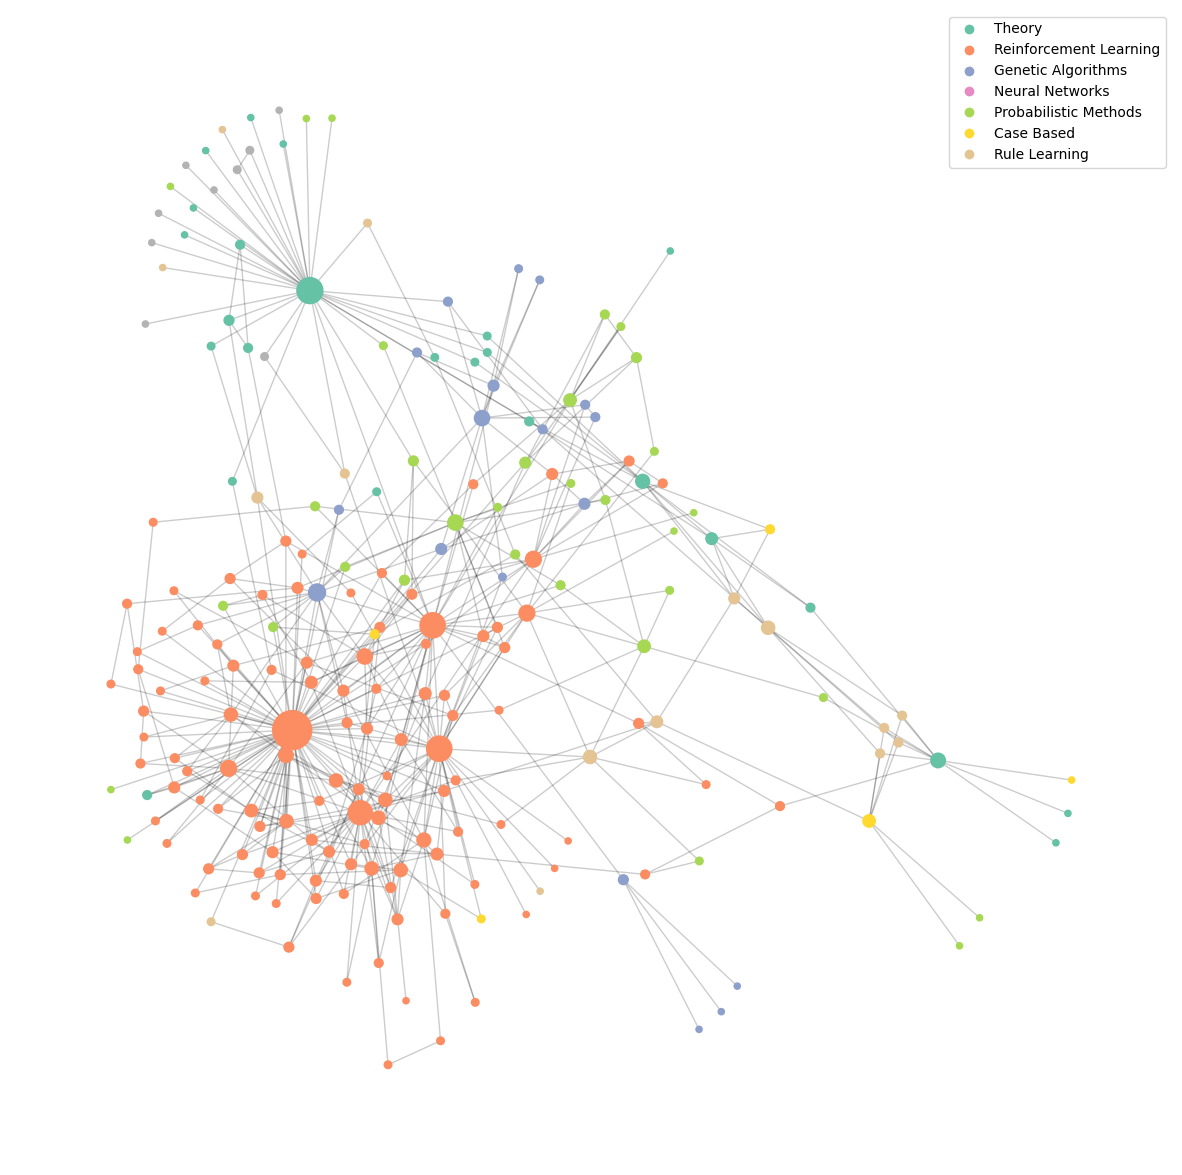

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
pos = subgraph_layout(dataset.data, seed=0)
plot_subset(dataset.data, ax, pos)

colours = plt.get_cmap().colors
handles = [plt.Line2D([0,], [0,], marker='o', color=colour, lw=0) for colour in colours]
ax.legend(handles, [label_map[i] for i in range(len(label_map))])

Now analyse the distribution of node labels on the graph:
* Can you observe the similarity in labels between nodes that are connected in the network?
* Can you think of a way of quantifying such similarity?
* Implement the following definition of homophily as defined in [Zhu et al. (2020)](https://arxiv.org/abs/2006.11468):

 $$h = \frac{ | \{ \{u,v\} : \{u, v\} \in E \text{ and } y_u = y_v\}|}{|E|},$$

 and use this to calculate homophily of the Cora citation network.

In [16]:
type(dataset.data)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3152573567.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  type(dataset.data)


torch_geometric.data.data.Data

In [17]:
import torch

def homophily(data):
    """
    h = |{ {u,v} in E : y_u == y_v }| / |E|
    Uses unique undirected edges (u < v) and drops self-loops.
    Works with torch_geometric.data.Data (e.g., Cora).
    """
    edge_index = data.edge_index
    y = data.y.view(-1)

    row, col = edge_index[0], edge_index[1]

    # Drop self-loops
    mask = row != col
    row, col = row[mask], col[mask]

    # Use each undirected edge once (u < v). If graph is directed (no pairs), fall back to all.
    undirected_mask = row < col
    if undirected_mask.any():
        u, v = row[undirected_mask], col[undirected_mask]
    else:
        u, v = row, col  # directed case

    same = (y[u] == y[v]).to(torch.float32)
    return (same.sum() / same.numel()).item() if same.numel() > 0 else float('nan')

print('Cora homophily:', homophily(dataset.data))

Cora homophily: 0.8099659085273743


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/4126257847.py:28: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print('Cora homophily:', homophily(dataset.data))


We will be considering a semi-supervised node classification task, where we wish to label the nodes for which we do not have labels (fields where papers were published) given a set of nodes with known labels as well as the citation network.

* From the above observation, could you justify the use of graph neural networks for this task?

The topic of a paper can be largely derived from individual features (i.e., the abstract) and from the network of other papers a given piece of work is related to, which justifies the graph-based approach considered.

## Implementing GNNs

We are now ready to use PyG to implement graph neural networks. We will follow the simple graph convolutional network (GCN) model proposed by [Kipf and Welling (2017)](https://arxiv.org/abs/1609.02907), which is covered in the lectures. We will consider a network that consists of 2 GCN convolutional layers each of which is enhanced by a non-linear activation function. After that, we apply a simple linear transformation which acts as a classifier.

In [109]:
## Class defining the Graph Convolutional layer
class GCN(torch.nn.Module):

    def __init__(self, dropout=0.0, hidden_layers: int = 3, hidden_features: int = 16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_features) # The first layer map the node features to a 30-dimensional vector.
        for i in range(1, hidden_layers):
            setattr(self, f"conv{i+1}", GCNConv(hidden_features, hidden_features))
        
        self.classifier = Linear(hidden_features, dataset.num_classes) # The last layer is linear and output class scores.
        self.dropout = dropout

    def forward(self, x, edge_index):
        # After each convolutional layer we apply a relu non linear transformation and dropout (optional).
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = torch.nn.functional.dropout(h, p=self.dropout)

        h = self.conv2(h, edge_index)
        h = h.relu() # node embeddings
        h = torch.nn.functional.dropout(h, p=self.dropout)

        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h

model = GCN()
print("Model architecture:")
print(model)
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {gcn_total_params}")

Model architecture:
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (classifier): Linear(in_features=16, out_features=7, bias=True)
)
Number of parameters: 23607


In [110]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h

def validation(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

def test(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.test_mask], data.y[data.test_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {"Training_Loss": [], 'Training_Acc': [], "Validation_Loss": [], "Validation_Acc": [],
     "Test_Loss": [], "Test_Acc": [], "epoch" : []}
for epoch in range(100):
    loss, train_acc, h = train(dataset.data)
    valid_loss, valid_acc, h = validation(dataset.data)
    test_loss, test_acc, h = validation(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(valid_loss)
    d["Validation_Acc"].append(valid_acc)
    d["Test_Loss"].append(test_loss)
    d["Test_Acc"].append(test_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {valid_acc}, Test Accuracy {test_acc}")

model.eval()
_, h_post = model(dataset.data.x, dataset.data.edge_index)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/764113187.py:40: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  loss, train_acc, h = train(dataset.data)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/764113187.py:41: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  valid_loss, valid_acc, h = validation(dataset.data)
/var/folders/hz/6s1x39g16f1

Epoch 0: Training Accuracy 0.14285714285714285, Validation Accuracy 0.122, Test Accuracy 0.122
Epoch 10: Training Accuracy 0.9214285714285714, Validation Accuracy 0.628, Test Accuracy 0.628
Epoch 20: Training Accuracy 1.0, Validation Accuracy 0.77, Test Accuracy 0.77
Epoch 30: Training Accuracy 1.0, Validation Accuracy 0.766, Test Accuracy 0.766
Epoch 40: Training Accuracy 1.0, Validation Accuracy 0.766, Test Accuracy 0.766
Epoch 50: Training Accuracy 1.0, Validation Accuracy 0.766, Test Accuracy 0.766
Epoch 60: Training Accuracy 1.0, Validation Accuracy 0.764, Test Accuracy 0.764
Epoch 70: Training Accuracy 1.0, Validation Accuracy 0.764, Test Accuracy 0.764
Epoch 80: Training Accuracy 1.0, Validation Accuracy 0.764, Test Accuracy 0.764
Epoch 90: Training Accuracy 1.0, Validation Accuracy 0.766, Test Accuracy 0.766


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/764113187.py:54: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, h_post = model(dataset.data.x, dataset.data.edge_index)


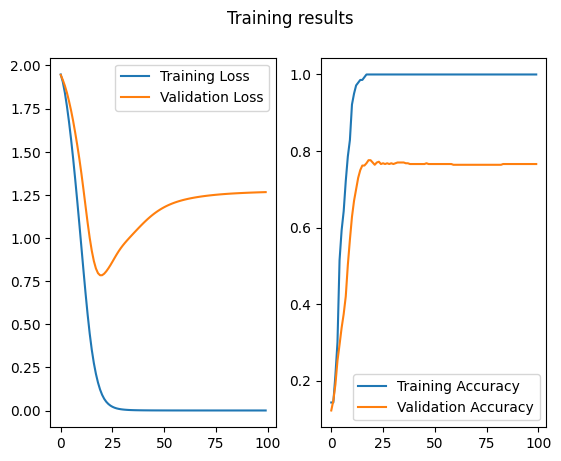

In [111]:
### Plot results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training results')

Training_Loss = [l.detach().numpy() for l in d["Training_Loss"]]
Validation_Loss = [l.detach().numpy() for l in d["Validation_Loss"]]

ax1.plot(d["epoch"], Training_Loss, label='Training Loss')
ax1.plot(d["epoch"], Validation_Loss, label='Validation Loss')
ax1.legend()

ax2.plot(d["epoch"], d["Training_Acc"], label='Training Accuracy')
ax2.plot(d["epoch"], d["Validation_Acc"], label='Validation Accuracy')
ax2.legend();

## Using a large number of layers

In [112]:
model = GCN(
    hidden_layers=50
)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h

def validation(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

def test(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.test_mask], data.y[data.test_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {"Training_Loss": [], 'Training_Acc': [], "Validation_Loss": [], "Validation_Acc": [],
     "Test_Loss": [], "Test_Acc": [], "epoch" : []}
for epoch in range(100):
    loss, train_acc, h = train(dataset.data)
    valid_loss, valid_acc, h = validation(dataset.data)
    test_loss, test_acc, h = validation(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(valid_loss)
    d["Validation_Acc"].append(valid_acc)
    d["Test_Loss"].append(test_loss)
    d["Test_Acc"].append(test_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {valid_acc}, Test Accuracy {test_acc}")

model.eval()
_, h_post = model(dataset.data.x, dataset.data.edge_index)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/792767262.py:42: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  loss, train_acc, h = train(dataset.data)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/792767262.py:43: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  valid_loss, valid_acc, h = validation(dataset.data)
/var/folders/hz/6s1x39g16f1

Epoch 0: Training Accuracy 0.12857142857142856, Validation Accuracy 0.088, Test Accuracy 0.088
Epoch 10: Training Accuracy 0.7357142857142858, Validation Accuracy 0.552, Test Accuracy 0.552
Epoch 20: Training Accuracy 0.8785714285714286, Validation Accuracy 0.622, Test Accuracy 0.622
Epoch 30: Training Accuracy 0.9928571428571429, Validation Accuracy 0.71, Test Accuracy 0.71
Epoch 40: Training Accuracy 1.0, Validation Accuracy 0.754, Test Accuracy 0.754
Epoch 50: Training Accuracy 1.0, Validation Accuracy 0.774, Test Accuracy 0.774
Epoch 60: Training Accuracy 1.0, Validation Accuracy 0.774, Test Accuracy 0.774
Epoch 70: Training Accuracy 1.0, Validation Accuracy 0.772, Test Accuracy 0.772
Epoch 80: Training Accuracy 1.0, Validation Accuracy 0.772, Test Accuracy 0.772
Epoch 90: Training Accuracy 1.0, Validation Accuracy 0.774, Test Accuracy 0.774


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/792767262.py:56: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, h_post = model(dataset.data.x, dataset.data.edge_index)


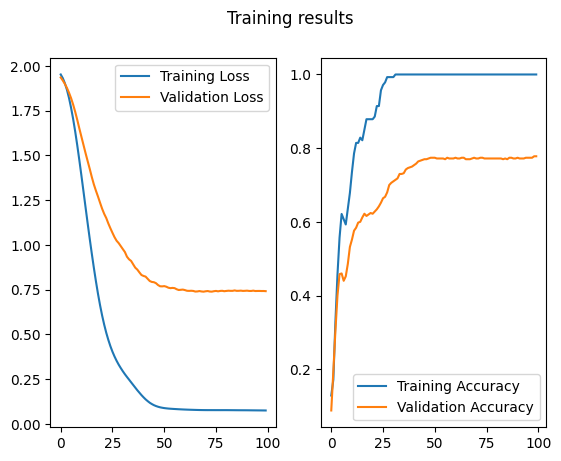

In [113]:
### Plot results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training results')

Training_Loss = [l.detach().numpy() for l in d["Training_Loss"]]
Validation_Loss = [l.detach().numpy() for l in d["Validation_Loss"]]

ax1.plot(d["epoch"], Training_Loss, label='Training Loss')
ax1.plot(d["epoch"], Validation_Loss, label='Validation Loss')
ax1.legend()

ax2.plot(d["epoch"], d["Training_Acc"], label='Training Accuracy')
ax2.plot(d["epoch"], d["Validation_Acc"], label='Validation Accuracy')
ax2.legend();

## Using a small number of layers, and large hidden dimension

In [114]:
model = GCN(
    hidden_layers=5, hidden_features=256
)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h

def validation(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

def test(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.test_mask], data.y[data.test_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {"Training_Loss": [], 'Training_Acc': [], "Validation_Loss": [], "Validation_Acc": [],
     "Test_Loss": [], "Test_Acc": [], "epoch" : []}
for epoch in range(100):
    loss, train_acc, h = train(dataset.data)
    valid_loss, valid_acc, h = validation(dataset.data)
    test_loss, test_acc, h = validation(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(valid_loss)
    d["Validation_Acc"].append(valid_acc)
    d["Test_Loss"].append(test_loss)
    d["Test_Acc"].append(test_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {valid_acc}, Test Accuracy {test_acc}")

model.eval()
_, h_post = model(dataset.data.x, dataset.data.edge_index)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3365180039.py:42: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  loss, train_acc, h = train(dataset.data)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3365180039.py:43: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  valid_loss, valid_acc, h = validation(dataset.data)
/var/folders/hz/6s1x39g16

Epoch 0: Training Accuracy 0.14285714285714285, Validation Accuracy 0.148, Test Accuracy 0.148
Epoch 10: Training Accuracy 0.5428571428571428, Validation Accuracy 0.4, Test Accuracy 0.4
Epoch 20: Training Accuracy 0.4785714285714286, Validation Accuracy 0.32, Test Accuracy 0.32
Epoch 30: Training Accuracy 0.8857142857142857, Validation Accuracy 0.556, Test Accuracy 0.556
Epoch 40: Training Accuracy 0.9428571428571428, Validation Accuracy 0.552, Test Accuracy 0.552
Epoch 50: Training Accuracy 0.9642857142857143, Validation Accuracy 0.656, Test Accuracy 0.656
Epoch 60: Training Accuracy 0.9785714285714285, Validation Accuracy 0.678, Test Accuracy 0.678
Epoch 70: Training Accuracy 0.9642857142857143, Validation Accuracy 0.68, Test Accuracy 0.68
Epoch 80: Training Accuracy 0.9785714285714285, Validation Accuracy 0.698, Test Accuracy 0.698
Epoch 90: Training Accuracy 0.9785714285714285, Validation Accuracy 0.682, Test Accuracy 0.682


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3365180039.py:56: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, h_post = model(dataset.data.x, dataset.data.edge_index)


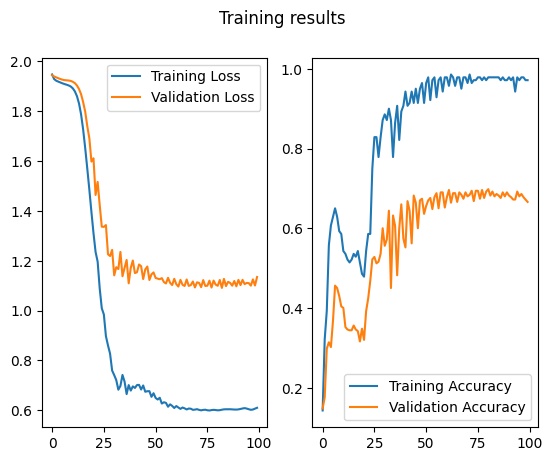

In [115]:
### Plot results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training results')

Training_Loss = [l.detach().numpy() for l in d["Training_Loss"]]
Validation_Loss = [l.detach().numpy() for l in d["Validation_Loss"]]

ax1.plot(d["epoch"], Training_Loss, label='Training Loss')
ax1.plot(d["epoch"], Validation_Loss, label='Validation Loss')
ax1.legend()

ax2.plot(d["epoch"], d["Training_Acc"], label='Training Accuracy')
ax2.plot(d["epoch"], d["Validation_Acc"], label='Validation Accuracy')
ax2.legend();

Tips on GNN training:
- Graph neural network models are known to suffer from a feature oversmoothing phenomenon on node representation (can you see why?), as discussed in [Li et al. (2018)](https://arxiv.org/abs/1801.07606). As a result, stacking too many layers in GNN does not result in better performance contrary to classical deep learning architecture. When applying GNNs in the real world, a small number of layers (2 or 3) often results in the best performances.
- Play around with the hidden feature dimensions.
- Control overfitting with weight decay (L2 regularization) and dropout.

Now compare the node representations before and after applying the GNNs. Show the t-SNE visualisation of the initial node representation (input features) and the representations learned by the GNN:

* Can you comment on the two visualisations and what the GNN has obtained?
* What about if you make minor changes to the architecture, e.g., increase the number of GCN layers?

In [116]:
def visualise_tsne(features, labels, ax):
    z = TSNE(n_components=2).fit_transform(features.detach().cpu().numpy())
    ax.scatter(z[:, 0], z[:, 1], s=70, c=labels)
    ax.axis("off")

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/45739741.py:7: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  visualise_tsne(dataset.data.x, dataset.data.y, axs[0])
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/45739741.py:8: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  visualise_tsne(h_post, dataset.data.y, axs[1])


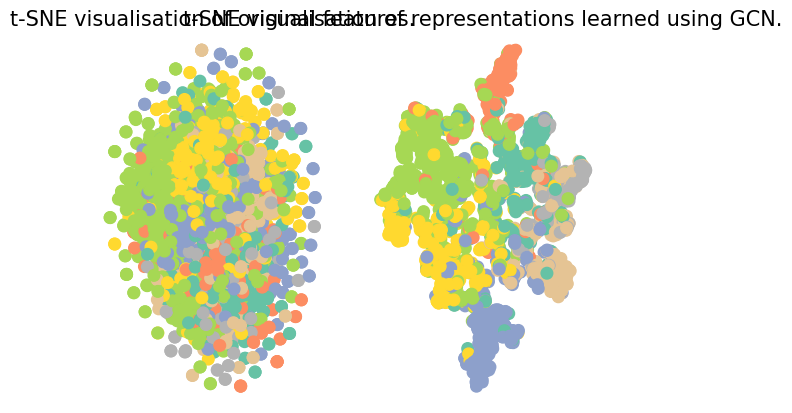

In [117]:
# note this may take a minute or two to run

fig, axs = plt.subplots(1, 2)
axs[0].set_title('t-SNE visualisation of original features.', fontsize=15)
axs[1].set_title('t-SNE visualisation of representations learned using GCN.', fontsize=15)
axs[0].axis('off'); axs[1].axis('off')
visualise_tsne(dataset.data.x, dataset.data.y, axs[0])
visualise_tsne(h_post, dataset.data.y, axs[1])

Now compare the performance of GNN-based approach with two simple baselines: <br>
1) A multi-layer perception (MLP) network, which makes use of the input node features but not the graph topology; <br>
2) A simple label propogation approach proposed in [Zhou and Schölkopf (2004)](https://www.microsoft.com/en-us/research/publication/regularization-framework-learning-graph-data/), which uses the graph topology but not the input node features.

First, implement the MLP.

In [118]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = Linear(dataset.num_features, 40)
        self.lin2 = Linear(40, 10)
        self.classifier = Linear(10, dataset.num_classes)

    def forward(self, x):
        h = self.lin1(x)
        h = h.relu()
        h = self.lin2(h)
        h = h.relu()

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model_MLP = MLP()
pytorch_total_params = sum(p.numel() for p in model_MLP.parameters() if p.requires_grad)
print(pytorch_total_params)

57847


In [119]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01)  # Define optimizer.

model_MLP.eval()
_, h_initial = model_MLP(dataset.data.x) #Initial Latent Representation

def train_MLP(data):
    model_MLP.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model_MLP(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h

def validation_MLP(data):
    model_MLP.eval()
    out, h = model_MLP(data.x)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {}
d["Training_Loss"], d["Training_Acc"], d["Validation_Loss"], d["Validation_Acc"], d["epoch"] = [], [], [], [], []
for epoch in range(200):
    loss, train_acc, h = train_MLP(dataset.data)
    validation_loss, validation_acc, h = validation_MLP(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(validation_loss)
    d["Validation_Acc"].append(validation_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {validation_acc}")

model_MLP.eval()
_, h_post = model_MLP(dataset.data.x)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3527437499.py:5: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, h_initial = model_MLP(dataset.data.x) #Initial Latent Representation
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3527437499.py:33: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  loss, train_acc, h = train_MLP(dataset.data)
/v

Epoch 0: Training Accuracy 0.14285714285714285, Validation Accuracy 0.114
Epoch 10: Training Accuracy 0.8714285714285714, Validation Accuracy 0.428
Epoch 20: Training Accuracy 1.0, Validation Accuracy 0.508
Epoch 30: Training Accuracy 1.0, Validation Accuracy 0.464
Epoch 40: Training Accuracy 1.0, Validation Accuracy 0.416
Epoch 50: Training Accuracy 1.0, Validation Accuracy 0.396
Epoch 60: Training Accuracy 1.0, Validation Accuracy 0.4
Epoch 70: Training Accuracy 1.0, Validation Accuracy 0.406
Epoch 80: Training Accuracy 1.0, Validation Accuracy 0.416
Epoch 90: Training Accuracy 1.0, Validation Accuracy 0.418
Epoch 100: Training Accuracy 1.0, Validation Accuracy 0.422
Epoch 110: Training Accuracy 1.0, Validation Accuracy 0.424
Epoch 120: Training Accuracy 1.0, Validation Accuracy 0.424
Epoch 130: Training Accuracy 1.0, Validation Accuracy 0.426
Epoch 140: Training Accuracy 1.0, Validation Accuracy 0.428
Epoch 150: Training Accuracy 1.0, Validation Accuracy 0.428
Epoch 160: Training Ac

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3527437499.py:44: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, h_post = model_MLP(dataset.data.x)


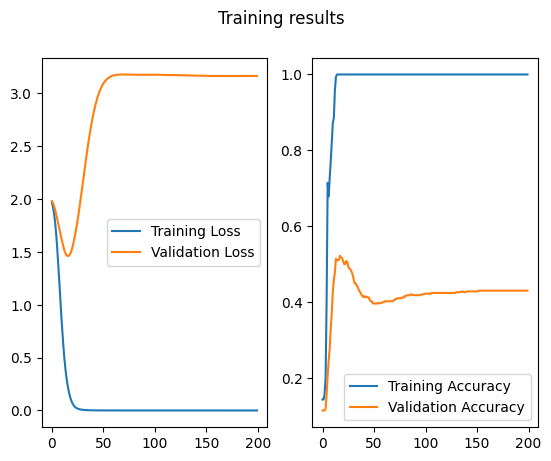

In [120]:
### Plot results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training results')

Training_Loss = [l.detach().numpy() for l in d["Training_Loss"]]
Validation_Loss = [l.detach().numpy() for l in d["Validation_Loss"]]

ax1.plot(d["epoch"], Training_Loss, label='Training Loss')
ax1.plot(d["epoch"], Validation_Loss, label='Validation Loss')
ax1.legend()

ax2.plot(d["epoch"], d["Training_Acc"], label='Training Accuracy')
ax2.plot(d["epoch"], d["Validation_Acc"], label='Validation Accuracy')
ax2.legend();

Visualise the representations learned by the MLP.

* Can you compare this with the visualisation of the representations learned by the GNN above?

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3538187870.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  visualise_tsne(h_post, dataset.data.y, ax)


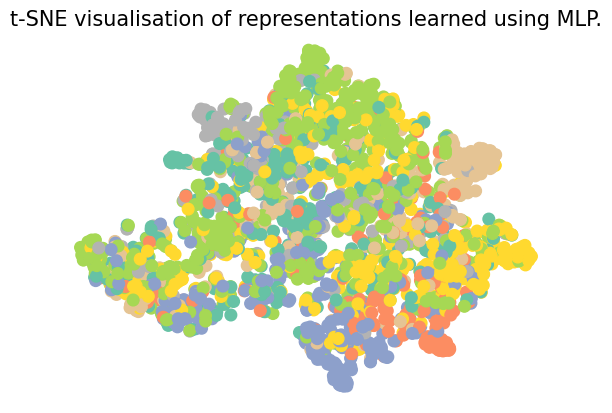

In [122]:
fig, ax = plt.subplots()
visualise_tsne(h_post, dataset.data.y, ax)
ax.set_title('t-SNE visualisation of representations learned using MLP.', fontsize=15)
ax.axis('off');

The label propagation approach in [Zhou and Schölkopf (2004)](https://www.microsoft.com/en-us/research/publication/regularization-framework-learning-graph-data/) simply learns labels by minimising the Dirichlet energy. A simple implementation is provided below for you to use. Pay attention to what information are used and what are left out:

In [123]:
def label_prop(dataset):
    G = to_networkx(dataset.data, node_attrs=['y'], to_undirected=True)
    train_id = dataset.data.train_mask
    labels = np.array(list(nx.get_node_attributes(G, 'y').values())).reshape(-1,1)
    # convert to one hot encode
    labels_one_hot = np.zeros((G.number_of_nodes(), labels.max()+1))
    for i in range(labels.max()+1):
        # if equal to label set 1, not equal to label set -1, unlabeled set to 0
        labels_one_hot[:np.sum(train_id.numpy()), i] = -1
        labels_one_hot[:np.sum(train_id.numpy()), i][(labels[train_id] == i).flatten()] = 1

    D = np.diag(np.array(nx.adjacency_matrix(G).todense()).sum(axis = 0)) # degree matrix
    A = nx.adjacency_matrix(G).todense() # weight matrix
    T = np.linalg.inv(D) @ A # lazy random walk

    alpha = 0.9 # from paper
    inv = np.linalg.inv(np.eye(T.shape[0]) - alpha*T)
    prob = inv @ labels_one_hot
    return prob[dataset.data.val_mask]

Label propagation returns probability-like vectors of belonging to each class. The prediction can be obtained by taking the class with highest probability.

In [124]:
label_prob = label_prop(dataset)
labels_val = labels[dataset.data.val_mask]

label_pred = np.argmax(label_prob, axis=1)
labels_val = labels_val.numpy()

accuracy = lambda pred, true: np.sum(pred == true) / len(true)

print(f'label propagation accuracy = {accuracy(label_pred, labels_val)}')

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/2677864253.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  G = to_networkx(dataset.data, node_attrs=['y'], to_undirected=True)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/2677864253.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  train_id = dataset.data.train_mask


label propagation accuracy = 0.69


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/2677864253.py:19: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  return prob[dataset.data.val_mask]


* What are the main differences between the three approaches (GNN, MLP, LP)?

GNN: uses topology-based information propagation. MLP based approach processes individual features. LP uses topology information as well, but with more focus on the connectivity of the nodes than their contents.

* Can you comment on the advantage of a GNN-based approach?

GNN use topology-based information and node-level characteristics explicitly.

* Can you tune the hyperparameters (e.g., hidden layer dimensions) to improve the performance of the GCN as best as you can? 

< done before >

**[Checkpoint 1]** You are now done with the first part of the exercises. Please ask a lab demonstrator to evaluate your work in this part.

## Analysing GNNs under topological perturbation

As you can imagine, the input graph topology plays an important role in the GNNs.

* What about if the input graph is noisy (e.g., due to inaccuracy in its construction) or perturbed (e.g., due to adversaries)?

Depending on topology as well, GCN's results for perturbed graphs are likely to change.

* What types of topological perturbations can you think of?

Edge deletion. Node-level features manipulation.

In this exercise, we will be looking into the following perturbation strategies: <br>


1.   Random perturbation of edges (random);
2.   A more strategic perturbation (DICE) from [Waniek et al. (2018)](https://www.nature.com/articles/s41562-017-0290-3).

The random strategy adds non-existent edges and removes present edges uniformly at random. The DICE strategy also samples edges, but will only sample edges to add if the endpoints have different labels and will only sample edges to remove if they have the same label. We provide code for both below.

In [125]:
def perturb_random(data, add, remove):
    """
    Add and remove edges uniformly at random.

    parameters:
        data: torch_geometric.data.data.Data input graph
        add: number of edges to add
        remove: number of edges to remove

    returns:
        a copy of the data with a perturbed graph
    """
    # so original data is not modified
    data = deepcopy(data)

    # networkx graph for convenient sampling
    graph_nx = to_networkx(data, to_undirected=True)

    # sample edges to remove
    edges = list(graph_nx.edges)
    edges_to_remove = [edges[i] for i in np.random.choice(range(len(edges)), remove, replace=False)]

    # sample edges to add
    edges_to_add = []
    while len(edges_to_add) < add:
        edge = list(np.random.choice(list(graph_nx.nodes()), 2, replace=False))
        edge = (min(edge), max(edge))
        if edge not in graph_nx.edges and edge not in edges_to_add:
            edges_to_add.append(edge)

    # now modify PyG edge index (graph topology)
    edge_index = data.edge_index

    # calculate row indices to delete (both directions)
    mask_idx = []
    for edge in edges_to_remove:
        mask_idx.append(torch.where((torch.tensor(edge) == edge_index.T).all(axis=1))[0].item())
        mask_idx.append(torch.where((torch.tensor(edge[::-1]) == edge_index.T).all(axis=1))[0].item())

    # delete rows using a mask
    mask = torch.ones(edge_index.T.size(0))
    mask[mask_idx] = 0
    edge_index = edge_index.T[mask.bool()].T

    # add edges
    edges_to_add = torch.tensor(edges_to_add)
    edges_to_add = torch.cat([edges_to_add, edges_to_add[:, [1, 0]]])
    edge_index = torch.cat((edge_index.T, edges_to_add)).T

    # assign new edges and return
    data.edge_index = edge_index
    return data

In [126]:
def perturb_dice(data, add, remove):
    """
    Add and remove edges using DICE (disconnect internally, connect externally)

    parameters:
        data: torch_geometric.data.data.Data input graph
        add: number of edges to add
        remove: number of edges to remove

    returns:
        a copy of the data with a perturbed graph
    """
    # so original data is not modified
    data = deepcopy(data)

    # networkx graph for convenient sampling
    graph_nx = to_networkx(data, to_undirected=True)

    # sample edges to remove
    edges = list(graph_nx.edges)
    edges_idx = [i for i, edge in enumerate(edges) if (data.y[edge[0]] == data.y[edge[1]]).item()]
    edges_to_remove = [edges[i] for i in np.random.choice(edges_idx, remove, replace=False)]

    # sample edges to add
    edges_to_add = []
    while len(edges_to_add) < add:
        edge = list(np.random.choice(list(graph_nx.nodes()), 2, replace=False))
        edge = (min(edge), max(edge))
        different_label = (data.y[edge[0]] != data.y[edge[1]]).item()
        if edge not in graph_nx.edges and edge not in edges_to_add and different_label:
            edges_to_add.append(edge)

    # now modify PyG edge index (graph topology)
    edge_index = data.edge_index

    # calculate row indices to delete (both directions)
    mask_idx = []
    for edge in edges_to_remove:
        mask_idx.append(torch.where((torch.tensor(edge) == edge_index.T).all(axis=1))[0].item())
        mask_idx.append(torch.where((torch.tensor(edge[::-1]) == edge_index.T).all(axis=1))[0].item())

    # delete rows using a mask
    mask = torch.ones(edge_index.T.size(0))
    mask[mask_idx] = 0
    edge_index = edge_index.T[mask.bool()].T

    # add edges
    edges_to_add = torch.tensor(edges_to_add)
    edges_to_add = torch.cat([edges_to_add, edges_to_add[:, [1, 0]]])
    edge_index = torch.cat((edge_index.T, edges_to_add)).T

    # assign new edges and return
    data.edge_index = edge_index
    return data

Visualise the perturbed graph data using the subset of the Cora data above:

* Similar to the above, can you compute the homophily level of node labels again?


In [127]:
print("homophily level of node labels: ", homophily(dataset.data))
print("homophily level of node labels: ", homophily(perturb_random(dataset.data, 1_000, 1_000)))
print("homophily level of node labels: ", homophily(perturb_dice(dataset.data, 1_000, 1_000)))

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/1231876583.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print("homophily level of node labels: ", homophily(dataset.data))
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/1231876583.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print("homophily level of node labels: ", homophily(p

homophily level of node labels:  0.8099659085273743
homophily level of node labels:  0.6917393207550049


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/1231876583.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print("homophily level of node labels: ", homophily(perturb_dice(dataset.data, 1_000, 1_000)))


homophily level of node labels:  0.6205002069473267


DICE decreases homophily more significantly, following from the more "targeted" approach to interventions that are operated.

* What do you observe compared to the case of clean graph? What consequence does this have on the GNN?

In [128]:
# perturb the graph using a budget of 0.5*|E| for add and remove (i.e. delete half the edges and add the same number back).
number_of_edges = int(dataset.data.num_edges / 2)
add = int(0.5 * number_of_edges)
remove = int(0.5 * number_of_edges)
data_random = perturb_random(dataset.data, add, remove)
data_dice = perturb_dice(dataset.data, add, remove)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3652912687.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  number_of_edges = int(dataset.data.num_edges / 2)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3652912687.py:5: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  data_random = perturb_random(dataset.data, add, remove)
/var/folders/h

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/2909078117.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  plot_subset(dataset.data, axs[0], pos=pos)


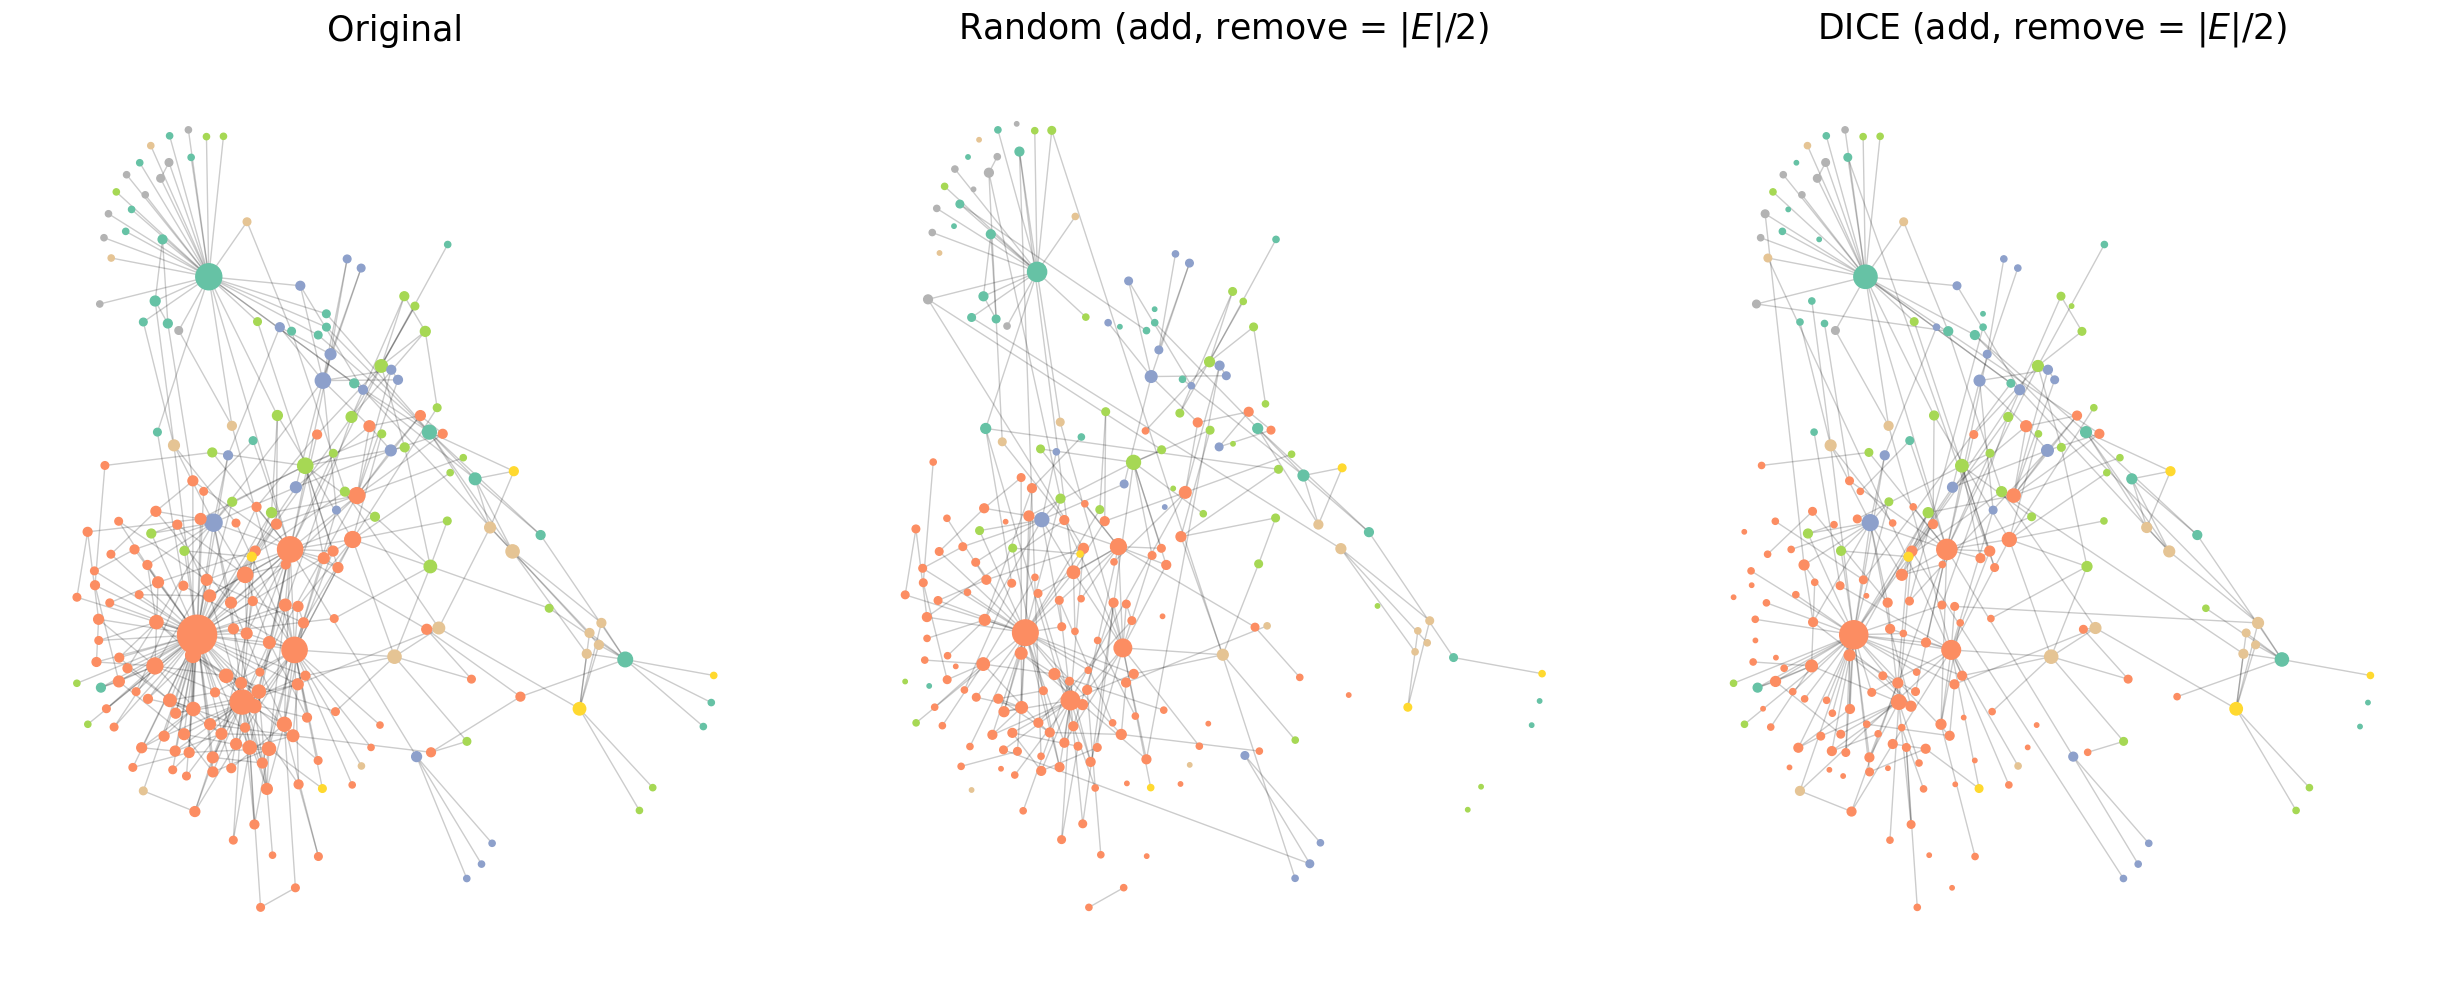

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))
fig.tight_layout()
plot_subset(dataset.data, axs[0], pos=pos)
plot_subset(data_random, axs[1], pos=pos)
plot_subset(data_dice, axs[2], pos=pos)
axs[0].set_title('Original', fontsize=25)
axs[1].set_title(r'Random (add, remove = $|E|/2$)', fontsize=25)
axs[2].set_title(r'DICE (add, remove = $|E|/2$)', fontsize=25);

Now consider the scenario where the input graph is clean during the training of the GNN model, but perturbed during inference (this corresponds to an *evasion* attack setting in the adversarial learning literature). Implement this using the perturbation strategies described above and compare the performance:

1) Train a GCN model using the original clean graph;<br/>
2) Perturb the clean graph using random perturbation or DICE, while keeping the node features unchanged;<br/>
3) Apply the trained GCN model to perturbed graph data to predict labels of testing nodes;<br/>
4) Repeat step 2) with a different amount of perturbation.

* Can you observe the relationship between performance drop and amount of perturbation?
* From this exercise, what can you say about the robustness of GNNs against topological perturbation, in the context of semi-supervised node classification? Hint: does the robustness depend on the homophily level of the node labels and, if yes, why?
* For a more in-depth and theoretical investigation of how the robustness of GNNs depend on topological properties of the perturbation, see [Kenlay et al. (2021)](https://arxiv.org/abs/2102.09587) and [Kenlay et al. (2021)](https://arxiv.org/abs/2010.13747).

In [130]:
# Train a GCN on the clean graph

model = GCN(
    hidden_layers=5, hidden_features=256
)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h

def validation(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

def test(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.test_mask], data.y[data.test_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {"Training_Loss": [], 'Training_Acc': [], "Validation_Loss": [], "Validation_Acc": [],
     "Test_Loss": [], "Test_Acc": [], "epoch" : []}
for epoch in range(100):
    loss, train_acc, h = train(dataset.data)
    valid_loss, valid_acc, h = validation(dataset.data)
    test_loss, test_acc, h = validation(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(valid_loss)
    d["Validation_Acc"].append(valid_acc)
    d["Test_Loss"].append(test_loss)
    d["Test_Acc"].append(test_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {valid_acc}, Test Accuracy {test_acc}")

model.eval()
_, h_post = model(dataset.data.x, dataset.data.edge_index)

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3094917866.py:44: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  loss, train_acc, h = train(dataset.data)
/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3094917866.py:45: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  valid_loss, valid_acc, h = validation(dataset.data)
/var/folders/hz/6s1x39g16

Epoch 0: Training Accuracy 0.1357142857142857, Validation Accuracy 0.29, Test Accuracy 0.29
Epoch 10: Training Accuracy 0.45714285714285713, Validation Accuracy 0.226, Test Accuracy 0.226
Epoch 20: Training Accuracy 0.7071428571428572, Validation Accuracy 0.55, Test Accuracy 0.55
Epoch 30: Training Accuracy 0.8785714285714286, Validation Accuracy 0.65, Test Accuracy 0.65
Epoch 40: Training Accuracy 0.9285714285714286, Validation Accuracy 0.64, Test Accuracy 0.64
Epoch 50: Training Accuracy 0.9071428571428571, Validation Accuracy 0.662, Test Accuracy 0.662
Epoch 60: Training Accuracy 0.95, Validation Accuracy 0.658, Test Accuracy 0.658
Epoch 70: Training Accuracy 0.9785714285714285, Validation Accuracy 0.666, Test Accuracy 0.666
Epoch 80: Training Accuracy 0.9642857142857143, Validation Accuracy 0.674, Test Accuracy 0.674
Epoch 90: Training Accuracy 0.9785714285714285, Validation Accuracy 0.69, Test Accuracy 0.69


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/3094917866.py:58: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, h_post = model(dataset.data.x, dataset.data.edge_index)


2) Perturb the clean graph using random perturbation or DICE, while keeping the node features unchanged;<br/>

In [131]:
data_dice  # already perturbed!

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

3) Apply the trained GCN model to perturbed graph data to predict labels of testing nodes;<br/>


In [137]:
model.eval()
logits, _ = model(data_dice.x, data_dice.edge_index)

In [147]:
_, clean_acc, _ = test(dataset.data)
_, dice_acc, _ = test(data_dice)

print(f"DICE accuracy: {dice_acc} (clean: {clean_acc})")

DICE accuracy: 0.34 (clean: 0.667)


/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/2321490464.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  _, clean_acc, _ = test(dataset.data)


4) Repeat step 2) with a different amount of perturbation.



In [150]:
add = int(1.1*add)
remove = int(1.1*remove)

data_dice = perturb_dice(dataset.data, add, remove)

_, dice_acc, _ = test(data_dice)
print(f"DICE accuracy: {dice_acc} (clean: {clean_acc})")

/var/folders/hz/6s1x39g16f11_vqs1b754l_80000gn/T/ipykernel_11730/2603456639.py:4: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  data_dice = perturb_dice(dataset.data, add, remove)


DICE accuracy: 0.269 (clean: 0.667)


As expected, accuracy decreases with higher amounts of noise.

**[Optional]** As an optional extension, read into a more advanced graph neural network architecture, the graph attention networks (GAT) from [Veličković et al. (2018)](https://arxiv.org/abs/1710.10903). Can you use PyTorch Geometric to implement the GAT and see how it performs compared to the GCN?

Blogpost : https://petar-v.com/GAT/

Tutorial for GAT : https://github.com/gordicaleksa/pytorch-GAT

**[Optional]** Repeat the node classification experiment above with datasets that come with heterophilous node labels, such as those included in [Zhu et al. (2020)](https://arxiv.org/abs/2006.11468) and [Luo et al. (2024)](https://arxiv.org/abs/2406.08993). Does the GCN still work well on those datasets and why?

## Over-squashing in GNNs

One problem with GNNs is the problem of over-squashing first studied in [Alon et al. (2021)](https://arxiv.org/abs/2006.05205). As seen in the lecture, this problem occurs when the graph possesses a topolohgy that causes bottlenecks in information propagation (message passing in the context of GNNs).

We now design a synthetic task which standard message-passing GNNs (the GCN can be thought of as an instance of these) cannot solve. We will use the dumbell graph, which consists of two clusters of nodes connected by a single edge as a bridge. This creates a bottleneck for messages of nodes in one cluster to be passed to those in the other.

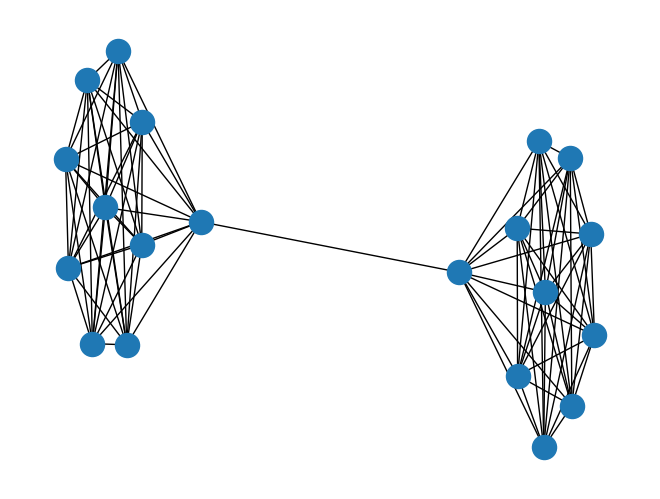

In [151]:
def dumbell_adj(N):
    "Builds adjacency matrix of a dumbell graph"
    A = np.zeros([2*N, 2*N])
    clq = np.ones([N, N]) - np.eye(N)
    A[:N, :N] = clq
    A[N:, N:] = clq
    A[N-1, N] = 1
    A[N, N-1] = 1
    return A

# Plot the dumbell
A = dumbell_adj(10)
G = nx.from_numpy_array(A)
nx.draw(G)

To illustrate over-squashing, we design a task that requires to send information from one cluster to the other. Input features will be sampled uniformly at random from two disjoint distirbutions. The task is a supervised nodel regression task that requires nodes from one cluster to output the mean of signal values on the nodes from the other cluster. This task is described in greater detail in [Bamberger et al. (2025)](https://arxiv.org/abs/2405.15540).

In [152]:
def gen_dumbell_signal(N):
    """ Generate input and output signals for the over-squashing task on the barbell."""
    mu1, mu2 = -np.sqrt(3*N), np.sqrt(3*N)
    std1, std2 = np.sqrt(N), np.sqrt(N)
    x1 = torch.empty([N, 1]).uniform_(mu1 - np.sqrt(3) * std1, mu1 + np.sqrt(3) * std1)
    x2 = torch.empty([N, 1]).uniform_(mu2 - np.sqrt(3) * std2, mu2 + np.sqrt(3) * std2)
    y1, y2 = x2.mean(dim=0).repeat(N, 1), x1.mean(dim=0).repeat(N, 1)
    x = torch.cat((x1, x2), dim=0)
    y = torch.cat((y1, y2), dim=0)
    return x, y

def generate_data(num_data=100, N=10):
    """ Creates a list of torch geometric Data object with dumbell graphs and input/output pairs.
        Unlike Cora, in this dataset we sample the input and output signals several times on the same graph.
    """
    A = dumbell_adj(N)
    edge_index,_ = dense_to_sparse(torch.tensor(A)) # convert to sparse tensor

    data_ls = []
    for i in range(num_data):
        x, y = gen_dumbell_signal(N)
        data = torch_geometric.data.Data(x = x, edge_index = edge_index, y = y)
        data_ls += [data]
    return data_ls

In [153]:
## Class defining the Graph Convolutional layer
class GCN(torch.nn.Module):

    def __init__(self, dropout=0.0, dim_inner=32):
        super(GCN, self).__init__()
        self.enc = Linear(1, dim_inner)  # encoder 
        self.conv1 = GCNConv(dim_inner, dim_inner) # The first layer map the node features to a 16-dimensional vector.
        self.conv2 = GCNConv(dim_inner, dim_inner) # The second layer output a 16-dimensional vector.
        self.conv3 = GCNConv(dim_inner, dim_inner) # The second layer output a 16-dimensional vector.
        self.regressor = Linear(dim_inner, 1) # The last layer is linear and output class scores.
        self.dropout = dropout

    def forward(self, x, edge_index):
        # After each convolutional layer we apply a relu non linear transformation and dropout (optional).
        h = self.enc(x)
        h = h.relu()
        h = torch.nn.functional.dropout(h, p=self.dropout)
        
        h = self.conv1(h, edge_index)
        h = h.relu()
        h = torch.nn.functional.dropout(h, p=self.dropout)

        h = self.conv2(h, edge_index)
        h = h.relu() # node embeddings
        h = torch.nn.functional.dropout(h, p=self.dropout)

        h = self.conv3(h, edge_index)
        h = h.relu() # node embeddings
        h = torch.nn.functional.dropout(h, p=self.dropout)

        # Apply a final (linear) classifier.
        out = self.regressor(h)
        return out

model = GCN()
print("Model architecture:")
print(model)
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {gcn_total_params}")

Model architecture:
GCN(
  (enc): Linear(in_features=1, out_features=32, bias=True)
  (conv1): GCNConv(32, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (regressor): Linear(in_features=32, out_features=1, bias=True)
)
Number of parameters: 3265


In [154]:
# Use above methods to define the train, validation and test data, as well as corresponding data loader. 
# Data loader are necessary since we sample the input and output several times on the graph.
train_data_ls = generate_data(50, N=20)
val_data_ls = generate_data(50, N=20)
test_data_ls = generate_data(50, N=20)
train_data_loader = DataLoader(train_data_ls, batch_size=10)
val_data_loader = DataLoader(val_data_ls, batch_size=10)
test_data_loader = DataLoader(test_data_ls, batch_size=10)

In [156]:
model = GCN(dim_inner=128)
criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)  # Define optimizer.
device = "cpu"

def train(data_loader):
    model.train()
    loss_ls = []

    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()  # Clear gradients.
        batch = batch.to(device)
        out = model(x=batch.x, edge_index=batch.edge_index)  # Forward on batch.
        loss = criterion(out, batch.y)  # Compute loss on batch.

        loss.backward()
        optimizer.step()
        loss_ls += [loss.detach()]
    return np.mean(loss_ls)  # average loss

def val(data_loader):
    model.eval()
    loss_ls = []

    for step, batch in enumerate(data_loader):
        batch = batch.to(device)
        out = model(x=batch.x, edge_index=batch.edge_index)  # Forward on batch.
        loss = criterion(out, batch.y)  # Compute loss on batch.
        loss_ls += [loss.detach()]
    return np.mean(loss_ls)  # average loss

d = {"Training_Loss": [], "Validation_Loss": [], "Test_Loss": [], "epoch" : []}
for epoch in range(100):
    loss_mean = train(train_data_loader)
    val_loss = val(val_data_loader)
    test_loss = val(test_data_loader)
    d["Training_Loss"].append(loss_mean)
    d["Validation_Loss"].append(val_loss)
    d["Test_Loss"].append(test_loss)

    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training_Loss {loss_mean}, Validation_Loss {val_loss}")

Epoch 0: Training_Loss 41.3117790222168, Validation_Loss 11.48343276977539
Epoch 10: Training_Loss 2.3510539531707764, Validation_Loss 1.6033893823623657
Epoch 20: Training_Loss 2.182129383087158, Validation_Loss 1.527367353439331
Epoch 30: Training_Loss 1.9450604915618896, Validation_Loss 1.4573066234588623
Epoch 40: Training_Loss 1.8736276626586914, Validation_Loss 1.5552918910980225
Epoch 50: Training_Loss 1.369458556175232, Validation_Loss 1.2536481618881226
Epoch 60: Training_Loss 1.3694555759429932, Validation_Loss 1.4190075397491455
Epoch 70: Training_Loss 1.4087399244308472, Validation_Loss 1.5452772378921509
Epoch 80: Training_Loss 1.445057988166809, Validation_Loss 1.5761353969573975
Epoch 90: Training_Loss 1.7271337509155273, Validation_Loss 1.9057199954986572


We now illustrate the benefit of graph rewiring in mitigating over-squashing. Rewiring as a remedy for over-squashing was introduced in [Topping et al. (2022)](https://arxiv.org/abs/2111.14522), by which the input graph topology is modified to make it more friendly for information propagation. More broadly, graph rewiring can refer to any such modification that better facilitates the downstream task.

In the next experiment, we design a simple rewiring scheme by adding "supporting edges" between the two clusters in the dumbell graph, and train the same architecture on the rewired graph.

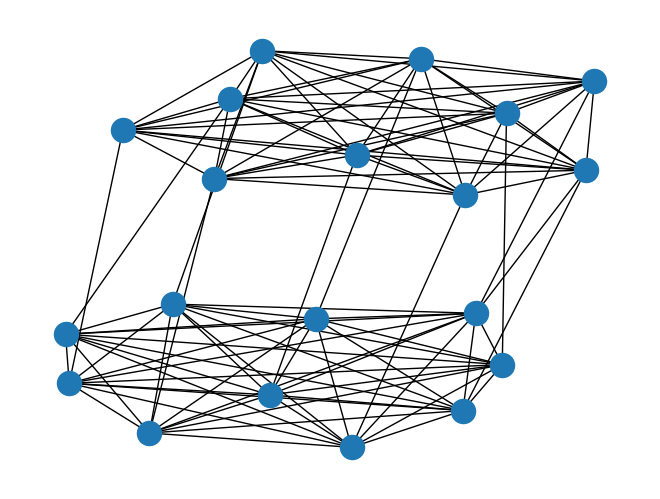

In [157]:
def rewired_dumbell_adj(N):
    "Build adjacency matrix of a dumbell graph"
    A = np.zeros([2*N, 2*N])
    clq = np.ones([N, N]) - np.eye(N)
    A[:N, :N] = clq
    A[N:, N:] = clq
    A[N-1, N] = 1
    A[N, N-1] = 1
    # rewire the graph by adding edges 'parallel' to the bottleneck edge
    for i in range(0, N):
        A[i, N+i] = 1
        A[i+N, i] = 1
    return A

def generate_rewired_data(num_data=100, N=10):
    "Create a list of torch geometric Data object with rewired dumbell graph and input/output pairs"
    A = rewired_dumbell_adj(N)
    edge_index,_ = dense_to_sparse(torch.tensor(A))
    data_ls = []
    for i in range(num_data):
        x, y = gen_dumbell_signal(N)
        data = torch_geometric.data.Data(x = x, edge_index = edge_index, y = y)
        data_ls += [data]
    return data_ls

# Plot the dumbell
A = rewired_dumbell_adj(10)
G = nx.from_numpy_array(A)
nx.draw(G)

In [159]:
# Build train, val, and test on rewired graph
train_data_ls = generate_rewired_data(50, N=20)
val_data_ls = generate_rewired_data(50, N=20)
test_data_ls = generate_rewired_data(50, N=20)
train_data_loader = DataLoader(train_data_ls, batch_size=10)
val_data_loader = DataLoader(val_data_ls, batch_size=10)
test_data_loader = DataLoader(test_data_ls, batch_size=10)


model = GCN(dim_inner=32)
criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)  # Define optimizer.
device = "cpu"

d = {"Training_Loss": [], "Validation_Loss": [], "Test_Loss": [], "epoch" : []}
for epoch in range(100):
    loss_mean = train(train_data_loader)
    val_loss = val(val_data_loader)
    test_loss = val(test_data_loader)
    d["Training_Loss"].append(loss_mean)
    d["Validation_Loss"].append(val_loss)
    d["Test_Loss"].append(test_loss)

    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training_Loss {loss_mean}, Validation_Loss {val_loss}")

Epoch 0: Training_Loss 30.956253051757812, Validation_Loss 4.552272796630859
Epoch 10: Training_Loss 2.068845510482788, Validation_Loss 1.9287351369857788
Epoch 20: Training_Loss 1.8360130786895752, Validation_Loss 1.6679271459579468
Epoch 30: Training_Loss 1.6898740530014038, Validation_Loss 1.4934204816818237
Epoch 40: Training_Loss 1.5482432842254639, Validation_Loss 1.3513712882995605
Epoch 50: Training_Loss 1.3810937404632568, Validation_Loss 1.210857629776001
Epoch 60: Training_Loss 1.3008145093917847, Validation_Loss 1.14674711227417
Epoch 70: Training_Loss 1.1326892375946045, Validation_Loss 1.1306108236312866
Epoch 80: Training_Loss 1.0617690086364746, Validation_Loss 0.9311334490776062
Epoch 90: Training_Loss 0.9323914647102356, Validation_Loss 0.8427073359489441


We can observe empirically that the task is better solved with a GCN trained on the modified graph topology, where the added supporting edges helped facilitate information propagation from one cluster to the other.

**[Optional]** An alternative to graph rewiring is to use a graph transformer architecture that makes distant nodes communicate with each other via attention, hence bypassing the limitation of message-passing GNNs. For a good introduction to graph transformers, you can check [Rampášek et al. (2022)](https://arxiv.org/abs/2205.12454).

**[Checkpoint 2]** You are now done with the second part of the exercises. Please ask a lab demonstrator to evaluate your work in this part.